In [1]:
# imports
from sympy import diff, symbols, exp, Eq, solve
from sympy.abc import t
import sympy

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from dataclasses import dataclass, field

import control

# State Space Model:

$$\frac{dC_A}{dt}=\frac{F}{V}\left(C_{A0}-C_A\right)-k_1(T)C_A\left(C_A+C_{B0}-C_{A0}\right)$$

$$\frac{dC_S}{dt}=\frac{F}{V}\left(C_{S0}-C_S\right)-k_2(T)C_S$$

$$\frac{dT}{dt}=\frac{F}{V}\left(T_0-T\right)+\frac{-\Delta H_1k_1(T)C_A\left(C_A+C_{B0}-C_{A0}\right)-\Delta H_2k_2(T)C_S}{\rho C_p}-\frac{UA\left(T-T_c\right)}{V\rho C_p}$$

## Define symbolic state space

InletConditions(F_A0=1075, F_S0=750, F_B0=1275, v_0=250.0, C_A0=4.3, C_B0=5.1, C_S0=3.0, F=3100)

In [ ]:
def state_space_zeros(y):
    f = y*0

    _C_A = y[0]
    _T = y[1]

    F = 250
    V = 4000
    C_A0 = 4.3
    C_B0 = 5.1
    C_S0 = 3
    T_0 = 410
    rho = 12.4
    C_P = 254
    U = 14.656e3
    A = 5.3
    T_c = 373

    _k_1 = 4e14 * np.exp(-1.28e5 / _T / 8.314)
    _k_2 = 1e84 * np.exp(-8e5 / _T / 8.314)
    
    _C_S = F / V * C_S0 / (F / V + _k_2)
    # _C_S = x[2]
    # f[2] = F / V * (C_S0 - _C_S) - _k_2 * _C_S


    f[0] = F / V * (C_A0 - _C_A) - _k_1 * _C_A * (_C_A + C_B0 - C_A0)
    f[1] = F / V * (T_0 - _T) + (-45400 * _k_1 * _C_A * (_C_A + C_B0 - C_A0) - 3.2e5 * _k_2 * _C_S) / rho / C_P - U * A * (_T - T_c) / rho / C_P / V

    return f

In [ ]:
# fsolve(state_space_zeros, [0.27, 0.1])

state_space_zeros(np.array([0.27, 460]))

In [2]:
# define symbolic state space equations
F, V, C_A0, C_A, k_1, T, C_A, C_B0, k_10, R, E_1, E_2, C_S0, C_S, E_2, k_20, H_1, H_2, T_0, T_c, UA, rho, C_p = symbols('F, V, C_A0, C_A, k_1, T, C_A, C_B0, k_10, R, E_1, E_2, C_S0, C_S, E_2, k_20, H_1, H_2, T_0, T_c, UA, rho, C_p')

C_As, C_Bs, C_Cs, C_Ss = symbols('C_As, C_Bs, C_Cs, C_Ss')

k_1 = k_10 * exp(-E_1 / T / R)
k_2 = k_20 * exp(-E_2 / T / R)

f_C_A = F / V * (C_A0 - C_A) - k_1 * C_A * (C_A + C_B0 - C_A0)

f_C_S = F / V * (C_S0 - C_S) - k_2 * C_S

f_T = F / V * (T_0 - T) + (-H_1 * k_1 * C_A * (C_A + C_B0 - C_A0) - H_2 * k_2 * C_S) / (rho * C_p) - (UA * (T - T_c)) / (V * rho * C_p)

In [3]:
_A_eq = Eq(0, f_C_A)

C_A_T = solve(_A_eq, C_A)[0]

C_A_T

(C_A0*V*k_10 - C_B0*V*k_10 - F*exp(E_1/(R*T)) - sqrt(C_A0**2*V**2*k_10**2 - 2*C_A0*C_B0*V**2*k_10**2 + 2*C_A0*F*V*k_10*exp(E_1/(R*T)) + C_B0**2*V**2*k_10**2 + 2*C_B0*F*V*k_10*exp(E_1/(R*T)) + F**2*exp(2*E_1/(R*T))))/(2*V*k_10)

In [4]:
_S_eq = Eq(0, f_C_S)

C_S_T = solve(_S_eq, C_S)[0]

C_S_T

C_S0*F*exp(E_2/(R*T))/(F*exp(E_2/(R*T)) + V*k_20)

In [ ]:
# def sys(x):
#     _T = x

#     F = 250
#     V = 4000
#     C_A0 = 4.3
#     C_B0 = 5.1
#     C_S0 = 3
#     T_0 = 410
#     rho = 12.4
#     C_P = 254
#     U = 14.656e3
#     A = 5.3
#     T_c = 373
#     k_10 = 4e14
#     k_20 = 1e84
#     E_1 = 1.28e5
#     E_2 = 8e5
#     _k_1 = 4e14 * np.exp(-1.28e5 / _T / 8.314)
#     _k_2 = 1e84 * np.exp(-8e5 / _T / 8.314)
#     R = 8.314

#     _C_S = (C_S0*F*np.exp(E_2/R/_T))/(F*np.exp(E_2/R/_T)+V*k_20)
#     _C_A = (C_A0*V*k_10-C_B0*V*k_10-F*np.exp(E_1/R/_T)-np.sqrt(C_A0**2*V**2*k_10**2-2*C_A0*C_B0*V**2*k_10**2+2*C_A0*F*V*k_10*np.exp(E_1/R/_T)+C_B0**2*V**2*k_10**2+2*C_B0*F*V*k_10*np.exp(E_1/R/_T)+F**2*np.exp(2*E_1/R/_T)))/(2*V*k_10)

#     G = (45400*_k_1*_C_A*(_C_A+C_B0-C_A0)+3.2e5*_k_2*_C_S)/(rho*C_P)
#     R = F/V*(T_0-_T)-U*A*(_T-T_c)/(V*rho*C_P)

#     return G, -R

# T_range = np.linspace(410, 600, 100)

# G, R = sys(T_range)

# plt.plot(T_range, G)
# plt.plot(T_range, R)

### Verify Equations

In [5]:
f_C_A

-C_A*k_10*(C_A - C_A0 + C_B0)*exp(-E_1/(R*T)) + F*(-C_A + C_A0)/V

In [6]:
f_C_S

-C_S*k_20*exp(-E_2/(R*T)) + F*(-C_S + C_S0)/V

In [7]:
f_T

F*(-T + T_0)/V - UA*(T - T_c)/(C_p*V*rho) + (-C_A*H_1*k_10*(C_A - C_A0 + C_B0)*exp(-E_1/(R*T)) - C_S*H_2*k_20*exp(-E_2/(R*T)))/(C_p*rho)

# Define system paramters

## Classes that define the system

In [5]:
# system classes
@dataclass
class SystemParameters():
    k_10: float
    E_1: float 
    k_20: float
    E_2: float
    H_1: float
    H_2: float
    rho: float
    C_p: float
    A: float
    T_c: float
    V: float

@dataclass
class InletConditions():
    F_A0: float
    F_S0: float
    F_B0: float
    v_0: float = field(init=False)
    C_A0: float = field(init=False)
    C_B0: float = field(init=False)
    C_S0: float = field(init=False)
    F: float = field(init=False)

    def __post_init__(self):
        self.F = self.F_A0 + self.F_B0 + self.F_S0

@dataclass
class SteadyState():
    U_s: float
    T_0s: float
    C_As: float = field(init=False)
    C_Ss: float = field(init=False)
    T_s: float = field(init=False)

## Initilize classes with given parameters

In [6]:
# initialize system classes
System_Params = SystemParameters(**{
    "k_10": 4e14,
    "E_1": 1.28e5,  
    "k_20": 1e84,
    "E_2": 8e5,
    "H_1": -45400,
    "H_2": -3.2e5,
    "rho": 12.4,
    "C_p": 254,
    "A": 5.3,
    "T_c": 373,
    "V": 4000,
})

Inlet_Conds = InletConditions(**{
    "F_A0": 1075,
    "F_S0": 750,
    "F_B0": 1275,
})

Inlet_Conds.v_0 = Inlet_Conds.F / System_Params.rho
Inlet_Conds.C_A0 = Inlet_Conds.F_A0 / Inlet_Conds.v_0
Inlet_Conds.C_B0 = Inlet_Conds.F_B0 / Inlet_Conds.v_0
Inlet_Conds.C_S0 = Inlet_Conds.F_S0 / Inlet_Conds.v_0

Steady_States = SteadyState(**{
    "U_s": 14.656e3,
    "T_0s": 410,
})

In [10]:
Inlet_Conds

InletConditions(F_A0=1075, F_S0=750, F_B0=1275, v_0=250.0, C_A0=4.3, C_B0=5.1, C_S0=3.0, F=3100)

In [7]:
C_A_T_subbed = C_A_T.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    UA: Steady_States.U_s * System_Params.A,
    T_c: System_Params.T_c,
    H_1: System_Params.H_1,
    H_2: System_Params.H_2,
    C_p: System_Params.C_p, 
    rho: System_Params.rho,
    C_B0: Inlet_Conds.C_B0,
})

C_A_T_subbed

-0.400000000000003*sqrt(4.58984374999993e-15*exp(15395.7180659129/T) + 3.81469726562495e-32*exp(30791.4361318258/T) + 1) - 7.8125e-17*exp(15395.7180659129/T) - 0.4

In [8]:
C_S_T_subbed = C_S_T.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    UA: Steady_States.U_s * System_Params.A,
    T_c: System_Params.T_c,
    H_1: System_Params.H_1,
    H_2: System_Params.H_2,
    C_p: System_Params.C_p, 
    rho: System_Params.rho,
    C_B0: Inlet_Conds.C_B0,
})

C_S_T_subbed

750.0*exp(0.120279047389945*E_2/T)/(250.0*exp(0.120279047389945*E_2/T) + 4.0e+87)

In [9]:
R_rxn = F / V * (T_0 - T) - (UA * (T - T_c)) / (V * rho * C_p)
G_rxn = (-H_1 * k_1 * C_A * (C_A + C_B0 - C_A0) - H_2 * k_2 * C_S) / (rho * C_p)
G_rxn

(-C_A*H_1*k_10*(C_A - C_A0 + C_B0)*exp(-E_1/(R*T)) - C_S*H_2*k_20*exp(-E_2/(R*T)))/(C_p*rho)

In [10]:
R_rxn

F*(-T + T_0)/V - UA*(T - T_c)/(C_p*V*rho)

In [27]:
R_subbed = R_rxn.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    UA: Steady_States.U_s * System_Params.A,
    T_c: System_Params.T_c,
    H_1: System_Params.H_1,
    H_2: System_Params.H_2,
    C_p: System_Params.C_p, 
    rho: System_Params.rho,
    C_B0: Inlet_Conds.C_B0,
    T_0: Steady_States.T_0s,
})

G_subbed = G_rxn.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    E_2: System_Params.E_2,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    UA: Steady_States.U_s * System_Params.A,
    T_c: System_Params.T_c,
    H_1: System_Params.H_1,
    H_2: System_Params.H_2,
    C_p: System_Params.C_p, 
    rho: System_Params.rho,
    C_B0: Inlet_Conds.C_B0,
})

In [28]:
G_subbed

5.76581153162306e+15*C_A*(C_A + 0.8)*exp(-15395.7180659129/T) + 1.01600203200406e+86*C_S*exp(-96223.2379119557/T)

In [16]:
R_subbed

27.9247719075438 - 0.0686656083312167*T

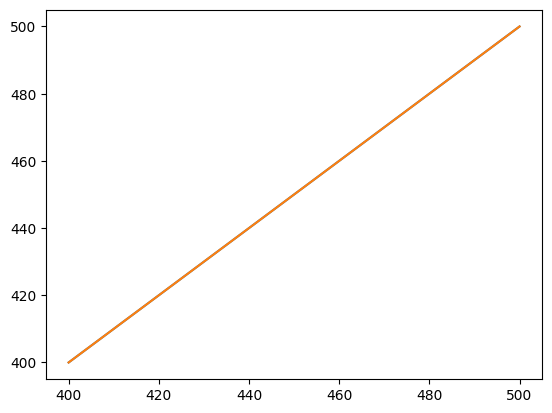

In [39]:
def sys(x):
    _T = x

    _C_A = C_A_T_subbed.subs({T: _T})
    _C_S = C_S_T_subbed.subs({T: _T})

    _G = G_subbed.subs({T: _T, C_A: _C_A, C_S: _C_S, E_2: System_Params.E_2})
    _R = R_subbed.subs({T: _T, C_A: _C_A, C_S: _C_S})

    return _G, _R

T_range = np.linspace(400, 500, 100)

g, r  = np.zeros(T_range.shape[0]), np.zeros(T_range.shape[0])

for i, val in enumerate(T_range):
    g[i], r[i] = val, val
# print(sys(400))

plt.plot(T_range, g)
plt.plot(T_range, r)

## Substitue parameters into state space

In [41]:
# substitute system paramters into state space
f_C_A_subbed = f_C_A.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_B0: Inlet_Conds.C_B0,
})

f_C_S_subbed = f_C_S.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    C_B0: Inlet_Conds.C_B0,
})

f_T_subbed = f_T.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    UA: Steady_States.U_s * System_Params.A,
    T_c: System_Params.T_c,
    H_1: System_Params.H_1,
    H_2: System_Params.H_2,
    C_p: System_Params.C_p, 
    rho: System_Params.rho,
    C_B0: Inlet_Conds.C_B0,
})

In [45]:
f_C_A_subbed

-400000000000000.0*C_A*(C_A + 0.8)*exp(-15395.7180659129/T) - 0.0625*C_A + 0.26875

In [ ]:
f_C_S_subbed

In [44]:
f_T_subbed

5.76581153162306e+15*C_A*(C_A + 0.8)*exp(-15395.7180659129/T) + 1.01600203200406e+86*C_S*exp(-0.120279047389945*E_2/T) - 0.0686656083312167*T + 0.0625*T_0 + 2.29977190754382

# Evaluate steady state

In [ ]:
# steady state evaluation

C_S_T = F/V * C_S0 / (F/V + k_2)

C_S_T_subbed = C_S_T.subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_S0: Inlet_Conds.C_S0,
    k_20: System_Params.k_20,
    C_B0: Inlet_Conds.C_B0,
})

C_A_T_eq = Eq(0, f_C_A)
C_A_T = solve(C_A_T_eq, C_A)
C_A_T_subbed = C_A_T[0].subs({
    C_A0: Inlet_Conds.C_A0,
    k_10: System_Params.k_10,
    R: 8.314,
    F: Inlet_Conds.v_0,
    V: System_Params.V,
    E_1: System_Params.E_1,
    C_B0: Inlet_Conds.C_B0,
})

def steady_state_system(x):
    f = x*0

    _T = x[0]

    _C_A = C_A_T_subbed.subs({T: _T})

    _C_S = C_S_T_subbed.subs({T: _T})

    # f[0] = f_C_A_subbed.subs({C_A: _C_A, C_S: _C_S, T: _T})
    f[0] = f_T_subbed.subs({C_A: _C_A, C_S: _C_S, T: _T, T_0: Steady_States.T_0s})

    return f

def steady_state_system_Jacobian(x):
    _C_A = x[0]
    _C_S = x[1]
    _T = x[2]
    
    _jac = sympy.matrices.Matrix([
        [
            f_C_A_subbed.diff(C_A).subs({C_A: _C_A, C_S: _C_S, T: _T}), 
            f_C_A_subbed.diff(C_S).subs({C_A: _C_A, C_S: _C_S, T: _T}), 
            f_C_A_subbed.diff(T).subs({C_A: _C_A, C_S: _C_S, T: _T})
        ],
        [
            f_C_S_subbed.diff(C_A).subs({C_A: _C_A, C_S: _C_S, T: _T}), 
            f_C_S_subbed.diff(C_S).subs({C_A: _C_A, C_S: _C_S, T: _T}), 
            f_C_S_subbed.diff(T).subs({C_A: _C_A, C_S: _C_S, T: _T})
        ],
        [
            f_T_subbed.diff(C_A).subs({C_A: _C_A, C_S: _C_S, T: _T, T_0: Steady_States.T_0s}), 
            f_T_subbed.diff(C_S).subs({C_A: _C_A, C_S: _C_S, T: _T, T_0: Steady_States.T_0s}), 
            f_T_subbed.diff(T).subs({C_A: _C_A, C_S: _C_S, T: _T, T_0: Steady_States.T_0s})
        ]
    ])

    return _jac

steady_state_solution = fsolve(steady_state_system, [410])
steady_state_solution

# steady_state_system(steady_state_solution)

In [ ]:
# save steady states
Steady_States.C_As = steady_state_solution[0]
Steady_States.C_Ss = steady_state_solution[1]
Steady_States.T_s = steady_state_solution[2]
Steady_States

# Steady state conversion

In [ ]:
# A conversion
1 - Steady_States.C_As / Inlet_Conds.C_A0

In [ ]:
# S conversion
1 - Steady_States.C_Ss / Inlet_Conds.C_S0

### Linearization

In [ ]:
# linear matrices
A = sympy.matrices.Matrix([
    [
        f_C_A_subbed.diff(C_A).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s}), 
        f_C_A_subbed.diff(C_S).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s}), 
        f_C_A_subbed.diff(T).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s})
    ],
    [
        f_C_S_subbed.diff(C_A).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s}), 
        f_C_S_subbed.diff(C_S).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s}), 
        f_C_S_subbed.diff(T).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s})
    ],
    [
        f_T_subbed.diff(C_A).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s}), 
        f_T_subbed.diff(C_S).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s}), 
        f_T_subbed.diff(T).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s})
    ],
])

b = sympy.matrices.Matrix([
    [f_C_A_subbed.diff(T_0).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s})],
    [f_C_S_subbed.diff(T_0).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s})],
    [f_T_subbed.diff(T_0).subs({C_A: Steady_States.C_As, C_S: Steady_States.C_Ss, T: Steady_States.T_s})],
])

c = sympy.matrices.Matrix([
    [0, 0, 1],
])

d = 0

state_vector = sympy.matrices.Matrix([
    [C_A],
    [C_S],
    [T],
])